# <center>Nixtla</center>

<p align="center" width="100%">
<img src="https://raw.githubusercontent.com/Nixtla/neuralforecast/main/nbs/indx_imgs/branding/logo_mid.png">
</p>  
 
<h1 align="center">Neural 🧠 Forecast</h1>
<h3 align="center">Deep Learninng for time series</h3>

[![CI Linux](https://github.com/Nixtla/neuralforecast/actions/workflows/ci-linux.yml/badge.svg?)](https://github.com/Nixtla/nixtlats/actions/workflows/ci-linux.yml)
[![CI Mac](https://github.com/Nixtla/neuralforecast/actions/workflows/ci-mac.yml/badge.svg?)](https://github.com/Nixtla/nixtlats/actions/workflows/ci-mac.yml)
[![codecov](https://codecov.io/gh/Nixtla/neuralforecast/branch/main/graph/badge.svg?token=C2P2BJI6S1)](https://codecov.io/gh/Nixtla/neuralforecast)
[![Python](https://img.shields.io/pypi/pyversions/neuralforecast)](https://pypi.org/project/neuralforecast/)
[![PyPi](https://img.shields.io/pypi/v/neuralforecast?color=blue)](https://pypi.org/project/neuralforecast/)
[![conda-nixtla](https://img.shields.io/conda/vn/nixtla/neuralforecast?color=seagreen&label=conda)](https://anaconda.org/nixtla/neuralforecast)
[![License: GPLv3](https://img.shields.io/badge/License-GPLv3-blue.svg)](https://github.com/Nixtla/neuralforecast/blob/main/LICENSE)
[![docs](https://img.shields.io/website-up-down-green-red/http/nixtla.github.io/neuralforecast.svg?label=docs)](https://nixtla.github.io/neuralforecast/)

State-of-the-art time series forecasting for pytorch.

`NeuralForecast` is a python library for time series forecasting with deep learning. 
It provides dataset loading utilities, evaluation functions and pytorch implementations of state of the art deep learning forecasting models.

## 📖 Documentation
Here is a link to the [documentation](https://nixtla.github.io/neuralforecast/).


## Installation

### Stable version

This code is a work in progress, any contributions or issues are welcome on
GitHub at: https://github.com/Nixtla/neuralforecast.

#### PyPI

You can install the *released version* of `NeuralForecast` from the [Python package index](https://pypi.org) with:

```python
pip install neuralforecast
```

(Installing inside a python virtualenvironment or a conda environment is recommended.)

#### Conda

Also you can install the *released version* of `NeuralForecast` from [conda](https://anaconda.org) with:

```python
conda install -c nixtla neuralforecast
```

(Installing inside a python virtualenvironment or a conda environment is recommended.)

### Development version in development mode

If you want to make some modifications to the code and see the effects in real time (without reinstalling), follow the steps below:

```bash
git clone https://github.com/Nixtla/neuralforecast.git
cd neuralforecast
pip install -e .
```


## Getting started

### Import libraries

In [ ]:
import pytorch_lightning as pl
from neuralforecast.data.datasets.long_horizon import LongHorizon
from neuralforecast.data.tsdataset import WindowsDataset
from neuralforecast.data.tsloader import TimeSeriesLoader
from neuralforecast.experiments.utils import get_mask_dfs
from neuralforecast.models.nhits.nhits import NHITS

### Dataset

In [ ]:
Y_df, _, _ = LongHorizon.load('data', 'ILI')
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


### Define TimeSeriesDataset and TimeSeriesLoader

In [ ]:
output_size = 24
input_size = 5 * output_size

In [ ]:
train_mask_df, val_mask_df, _ = get_mask_dfs(Y_df=Y_df, 
                                             ds_in_val=5 * output_size,
                                             ds_in_test=0)

<AxesSubplot:xlabel='ds'>

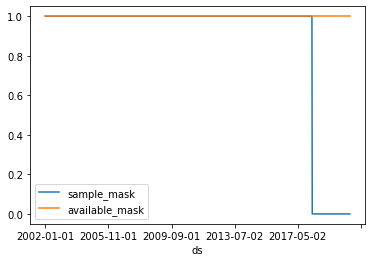

In [ ]:
train_mask_df.query('unique_id == "OT"').set_index('ds').plot()

<AxesSubplot:xlabel='ds'>

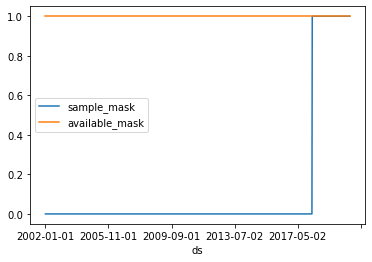

In [ ]:
val_mask_df.query('unique_id == "OT"').set_index('ds').plot()

In [ ]:
train_dataset = WindowsDataset(Y_df, 
                               input_size=input_size,
                               output_size=output_size,
                               mask_df=train_mask_df)

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)


In [ ]:
val_dataset = WindowsDataset(Y_df, 
                             input_size=input_size,
                             output_size=output_size,
                             mask_df=val_mask_df)

/Users/fedex/projects/neuralforecast/neuralforecast/data/tsdataset.py:208: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X.drop(['unique_id', 'ds'], 1, inplace=True)


In [ ]:
train_loader = TimeSeriesLoader(train_dataset, batch_size=1, 
                                n_windows=256,
                                shuffle=True)

In [ ]:
val_loader = TimeSeriesLoader(val_dataset, batch_size=1)

### Define model

In [ ]:
model = NHITS(n_time_in=input_size, n_time_out=output_size,
              n_x=0, n_s=0, n_s_hidden=[0], n_x_hidden=[0],
              shared_weights=False, initialization='lecun_normal',
              activation='ReLU', stack_types=3 * ['identity'],
              n_blocks= 3 * [1], n_layers= 9 * [2], n_theta_hidden=3 * [[512, 512]],
              n_pool_kernel_size=3 * [8], n_freq_downsample=[168, 24, 1],
              pooling_mode='max', interpolation_mode='linear',
              batch_normalization=False, dropout_prob_theta=0,
              learning_rate=1e-3, lr_decay=0.5, lr_decay_step_size=5, weight_decay=0,
              loss_train='MAE', loss_hypar=0, loss_valid='MAE',
              frequency='H', seasonality=24, random_seed=0)

### Train model with early stopping

In [ ]:
early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=1e-4, 
                                            patience=3, verbose=False,mode="min")

trainer = pl.Trainer(max_epochs=10, 
                     max_steps=100,
                     callbacks=[early_stopping])

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type   | Params
---------------------------------
0 | model | _NHITS | 1.0 M 
---------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.042     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fedex/opt/miniconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/Users/fedex/opt/miniconda3/envs/nixtla/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/fedex/opt/miniconda3/envs/nixtla/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:117: UserWarning: The dataloader, train_data

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [ ]:
model.forecast(Y_df, None, None)

NameError: name 'pd' is not defined

## Current available models

* [Exponential Smoothing Recurrent Neural Network (ES-RNN)](https://www.sciencedirect.com/science/article/pii/S0169207019301153): A hybrid model that combines the expressivity of non linear models to capture the trends while it normalizes using a Holt-Winters inspired model for the levels and seasonals.  This model is the winner of the M4 forecasting competition.

* [Neural Basis Expansion Analysis (N-BEATS)](https://arxiv.org/abs/1905.10437): A model from Element-AI (Yoshua Bengio’s lab) that has proven to achieve state of the art performance on benchmark large scale forecasting datasets like Tourism, M3, and M4. The model is fast to train an has an interpretable configuration.

* [Neural Basis Expansion Analysis with Exogenous Variables (N-BEATSx)](https://arxiv.org/abs/2104.05522): The neural basis expansion with exogenous variables is an extension to the original N-BEATS that allows it to include time dependent covariates.


## License
This project is licensed under the GPLv3 License - see the [LICENSE](https://github.com/Nixtla/neuralforecast/blob/main/LICENSE) file for details.

## How to contribute

See [CONTRIBUTING.md](https://github.com/Nixtla/neuralforecast/blob/main/CONTRIBUTING.md).

## How to cite

If you use `NeuralForecast` in a scientific publication, we encourage you to add
the following references to the related papers:


```bibtex
@article{neuralforecast_arxiv,
  author  = {XXXX},
  title   = {{NeuralForecast: Deep Learning for Time Series Forecasting}},
  journal = {arXiv preprint arXiv:XXX.XXX},
  year    = {2022}
}
```


## Contributors ✨

Thanks goes to these wonderful people ([emoji key](https://allcontributors.org/docs/en/emoji-key)):

<!-- ALL-CONTRIBUTORS-LIST:START - Do not remove or modify this section -->
<!-- prettier-ignore-start -->
<!-- markdownlint-disable -->
<table>
  <tr>
    <td align="center"><a href="https://github.com/FedericoGarza"><img src="https://avatars.githubusercontent.com/u/10517170?v=4?s=100" width="100px;" alt=""/><br /><sub><b>fede</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=FedericoGarza" title="Code">💻</a> <a href="https://github.com/Nixtla/neuralforecast/issues?q=author%3AFedericoGarza" title="Bug reports">🐛</a> <a href="https://github.com/Nixtla/neuralforecast/commits?author=FedericoGarza" title="Documentation">📖</a></td>
    <td align="center"><a href="https://github.com/gdevos010"><img src="https://avatars.githubusercontent.com/u/15316026?v=4?s=100" width="100px;" alt=""/><br /><sub><b>Greg DeVos</b></sub></a><br /><a href="#ideas-gdevos010" title="Ideas, Planning, & Feedback">🤔</a></td>
    <td align="center"><a href="https://github.com/cchallu"><img src="https://avatars.githubusercontent.com/u/31133398?v=4?s=100" width="100px;" alt=""/><br /><sub><b>Cristian Challu</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=cchallu" title="Code">💻</a> <a href="#data-cchallu" title="Data">🔣</a></td>
    <td align="center"><a href="https://github.com/mergenthaler"><img src="https://avatars.githubusercontent.com/u/4086186?v=4?s=100" width="100px;" alt=""/><br /><sub><b>mergenthaler</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=mergenthaler" title="Documentation">📖</a></td>
    <td align="center"><a href="https://github.com/kdgutier"><img src="https://avatars.githubusercontent.com/u/19935241?v=4?s=100" width="100px;" alt=""/><br /><sub><b>Kin</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=kdgutier" title="Code">💻</a> <a href="https://github.com/Nixtla/neuralforecast/issues?q=author%3Akdgutier" title="Bug reports">🐛</a> <a href="#data-kdgutier" title="Data">🔣</a></td>
    <td align="center"><a href="https://github.com/jmoralez"><img src="https://avatars.githubusercontent.com/u/8473587?v=4?s=100" width="100px;" alt=""/><br /><sub><b>José Morales</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=jmoralez" title="Code">💻</a></td>
    <td align="center"><a href="https://github.com/alejandroxag"><img src="https://avatars.githubusercontent.com/u/64334543?v=4?s=100" width="100px;" alt=""/><br /><sub><b>Alejandro</b></sub></a><br /><a href="https://github.com/Nixtla/neuralforecast/commits?author=alejandroxag" title="Code">💻</a></td>  
    <td align="center"><a href="http://lavattiata.com"><img src="https://avatars.githubusercontent.com/u/48966177?v=4?s=100" width="100px;" alt=""/><br /><sub><b>stefanialvs</b></sub></a><br /><a href="#design-stefanialvs" title="Design">🎨</a></td>
  </tr>
</table>

<!-- markdownlint-restore -->
<!-- prettier-ignore-end -->

<!-- ALL-CONTRIBUTORS-LIST:END -->

This project follows the [all-contributors](https://github.com/all-contributors/all-contributors) specification. Contributions of any kind welcome!

<!---

## Citing

```bibtex
@article{,
    author = {},
    title = {{}},
    journal = {},
    year = {}
}
```
-->